# Imports

In [207]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn import metrics
import bokeh.plotting as bp
import itertools

# Creating the dataframes for soil moisture

In [231]:
# This function will add a zero to the beginning of a string if it is a certain length. 
# This allows the string to work with the next functions.
def add_zeros(string):
    if len(str(string)) == 7:
        return '0' + str(string)
    else:
        return str(string)

# This function will grab the year from the values in the first column of the raw data.
def grab_year(string):
    if len(str(string)) == 10:
        return str(string)[-6:-2]
    else:
        return str(string[-4:])
# This function will grab the state number from the values in the first column.
def grab_state(string):
    return str(string)[:2]

# This function will grab the division number from the values in the first column.
def grab_division(string):
    return str(string)[2:4]

### Actually pulling in the data.
This is done by using a for loop that will:
- loop through all the `soil_moisture` files
- bring in only certain predetermined columns as a dataframe
    - these columns are the id, week of the year, preipitation, average temperature, moisture in both soil layers, moisture anomly index, moisture in surface layer, moisture in underlying layer, palmer drought index, and crop moisture index.
- create new columns for each dataframe that will separate the year, state number, and division number into separate columns.
- filter out any data that isn't in Texas
- store that dataframe inside of a dictionary, with each key being `soil_moisture_year`

In [305]:
years_on_file = ['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
                 '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
years = {}
for year in years_on_file:
    df = pd.read_excel(f'soil_moisture_{year}.xlsx', header=None, usecols=[0, 1, 2, 3, 4, 21, 22, 23, 31, 34], 
                       dtype={0:'object', 1:'object'})
    df.columns = ['div_year', 'week', 'precip_total_inches', 'temp_average_F', 
                  'available_moisture_in_both_layers_start_in', 'moisture_anomaly_index', 
                  'available_moisture_surface_layer_in', 'available_moisture_underlying_layer_in',
                  'modified_palmer_drought_index', 'crop_moisture_index']
    
    df['div_year_with_zeros'] = df.div_year.apply(add_zeros)

    df['year'] = df.div_year_with_zeros.apply(grab_year)

    df['state'] = df.div_year_with_zeros.apply(grab_state)

    df['division'] = df.div_year_with_zeros.apply(grab_division)
    
    
    df = df[df.state == '41']
    
    years[f'soil_moisture_{year}'] = df

In [309]:
years['soil_moisture_1997'].head()

,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division
14716,41011997,1,0.0,46,1.61,-0.36,0.84,0.61,1.75,0.01,41011997,1997,41,01
14717,41011997,2,0.0,50,1.45,-0.45,0.58,0.61,1.36,0.02,41011997,1997,41,01
14718,41011997,3,0.0,56,1.19,-0.58,0.18,0.61,0.88,0.02,41011997,1997,41,01
14719,41011997,4,0.0,54,0.79,-0.58,0.00,0.59,0.41,-0.14,41011997,1997,41,01
14720,41011997,5,1.7,53,0.59,2.51,1.00,0.95,2.21,0.29,41011997,1997,41,01


### The data needs dates.
In it's current state, there is only year and week of a (usually) 52 week period. Reading through the data sources documentation, the week counter starts on March 1. With this is mind, a for loop is used to group by year and division and give that group a column with dates.

##### Specifically, the for loop functions as follows:
- An empty list (`list_of_div`) is created within the first for loop. This list will contain the separate dataframes for each year and division. 

In [329]:
for key in years:
    print(key)
    list_of_div = []
    for div_number in years[key].division.unique():
        df = years[key][years[key].division == div_number]
        df['date'] = f'{df.year.iloc[0]}-03-01'
        df['date'] = pd.to_datetime(df['date'])

        dates = []
        i=0
        for value in df.date:
            new_date = value + timedelta(days=i)
            dates.append(new_date)
            i += 7
    
        df['final_date'] = dates
        list_of_div.append(df)
    joined_df = pd.concat(list_of_div)
        
    years[key] = joined_df

soil_moisture_1997


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

soil_moisture_1998
soil_moisture_1999
soil_moisture_2000
soil_moisture_2001
soil_moisture_2002
soil_moisture_2003
soil_moisture_2004
soil_moisture_2005
soil_moisture_2006
soil_moisture_2007
soil_moisture_2008
soil_moisture_2009
soil_moisture_2010
soil_moisture_2011
soil_moisture_2012
soil_moisture_2013
soil_moisture_2014
soil_moisture_2015
soil_moisture_2016
soil_moisture_2017


In [330]:
years['soil_moisture_2017']

,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division,date,final_date
0,41012017,1,0.00,47.8,1.66,-0.40,0.48,0.98,1.00,0.02,41012017,2017,41,01,2017-03-01,2017-03-01
1,41012017,2,0.01,55.3,1.46,-0.61,0.11,0.98,0.50,0.02,41012017,2017,41,01,2017-03-01,2017-03-08
2,41012017,3,0.00,56.2,1.09,-0.79,0.00,0.93,-0.12,-0.32,41012017,2017,41,01,2017-03-01,2017-03-15
3,41012017,4,0.11,63.2,0.93,-0.93,0.00,0.85,-0.82,-0.91,41012017,2017,41,01,2017-03-01,2017-03-22
4,41012017,5,1.35,53.6,0.85,1.86,1.00,0.85,0.53,-0.28,41012017,2017,41,01,2017-03-01,2017-03-29
5,41012017,6,0.30,55.4,1.85,0.20,0.89,0.85,0.63,-0.19,41012017,2017,41,01,2017-03-01,2017-04-05
6,41012017,7,0.65,62.7,1.74,0.78,0.89,0.85,1.14,0.05,41012017,2017,41,01,2017-03-01,2017-04-12
7,41012017,8,0.29,65.4,1.74,0.14,0.42,0.85,1.57,0.13,41012017,2017,41,01,2017-03-01,2017-04-19
8,41012017,9,0.78,58.4,1.27,1.04,0.67,0.85,1.88,0.20,41012017,2017,41,01,2017-03-01,2017-04-26
9,4101201710,10,0.13,58.6,1.52,-0.08,0.26,0.85,1.75,0.16,4101201710,2017,41,01,2017-03-01,2017-05-03


In [331]:
soil = pd.concat(years).reset_index()
soil.head()

,level_0,level_1,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division,date,final_date
0,soil_moisture_1997,14716,41011997,1,0.0,46.0,1.61,-0.36,0.84,0.61,1.75,0.01,41011997,1997,41,01,1997-03-01,1997-03-01
1,soil_moisture_1997,14717,41011997,2,0.0,50.0,1.45,-0.45,0.58,0.61,1.36,0.02,41011997,1997,41,01,1997-03-01,1997-03-08
2,soil_moisture_1997,14718,41011997,3,0.0,56.0,1.19,-0.58,0.18,0.61,0.88,0.02,41011997,1997,41,01,1997-03-01,1997-03-15
3,soil_moisture_1997,14719,41011997,4,0.0,54.0,0.79,-0.58,0.00,0.59,0.41,-0.14,41011997,1997,41,01,1997-03-01,1997-03-22
4,soil_moisture_1997,14720,41011997,5,1.7,53.0,0.59,2.51,1.00,0.95,2.21,0.29,41011997,1997,41,01,1997-03-01,1997-03-29


In [332]:
soil.year.unique()

array(['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'], dtype=object)

In [333]:
soil.state.unique()

array(['41'], dtype=object)

In [334]:
soil.division.unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10'],
      dtype=object)

In [335]:
soil.week = soil.week.astype('int')
soil.week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58])

In [336]:
soil[soil.week == 20].head()

,level_0,level_1,div_year,week,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,div_year_with_zeros,year,state,division,date,final_date
19,soil_moisture_1997,14735,41011997,20,0.1,82.0,2.40,-0.62,0.0,1.80,3.89,0.19,41011997,1997,41,01,1997-03-01,1997-07-12
71,soil_moisture_1997,14787,41021997,20,0.0,84.0,4.82,-0.26,0.0,3.67,4.46,1.21,41021997,1997,41,02,1997-03-01,1997-07-12
123,soil_moisture_1997,14839,41031997,20,0.1,84.0,4.16,-0.54,0.0,3.23,3.02,-0.44,41031997,1997,41,03,1997-03-01,1997-07-12
175,soil_moisture_1997,14891,41041997,20,0.2,83.0,4.65,-0.61,0.0,3.70,2.00,-0.48,41041997,1997,41,04,1997-03-01,1997-07-12
227,soil_moisture_1997,14943,41051997,20,0.1,83.0,0.00,-0.80,0.0,0.00,0.18,-0.65,41051997,1997,41,05,1997-03-01,1997-07-12


In [337]:
soil.columns

Index(['level_0', 'level_1', 'div_year', 'week', 'precip_total_inches',
       'temp_average_F', 'available_moisture_in_both_layers_start_in',
       'moisture_anomaly_index', 'available_moisture_surface_layer_in',
       'available_moisture_underlying_layer_in',
       'modified_palmer_drought_index', 'crop_moisture_index',
       'div_year_with_zeros', 'year', 'state', 'division', 'date',
       'final_date'],
      dtype='object')

In [338]:
soil = soil[['state', 'division', 'year', 'week', 'date', 'final_date', 'precip_total_inches',
       'temp_average_F', 'available_moisture_in_both_layers_start_in',
       'moisture_anomaly_index', 'available_moisture_surface_layer_in',
       'available_moisture_underlying_layer_in', 'modified_palmer_drought_index',
       'crop_moisture_index']]

In [339]:
(soil[['available_moisture_in_both_layers_start_in', 'available_moisture_surface_layer_in', 
      'available_moisture_underlying_layer_in']]
 .assign(summation=(soil.available_moisture_surface_layer_in + soil.available_moisture_underlying_layer_in))
 .sample(10))

,available_moisture_in_both_layers_start_in,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,summation
2438,5.82,1.00,7.00,8.00
3637,6.40,0.00,6.11,6.11
3023,7.00,1.00,6.00,7.00
7271,3.62,0.00,2.91,2.91
1650,4.66,0.97,3.66,4.63
769,0.15,0.02,0.01,0.03
7396,0.55,0.30,0.49,0.79
10790,1.76,0.83,0.80,1.63
5632,7.00,0.71,6.00,6.71
3482,2.06,0.46,1.83,2.29


In [340]:
division_table = pd.DataFrame({'id':['01', '02', '03', '04', '05', '06', '07', '08', '09', '10'],
              'division_name':['high_plains', 'low_rolling_plains', 'north_central', 'east_texas', 'trans_pecos', 
                              'edwards_plateau', 'south_central', 'upper_coast', 'southern', 'lower_valley']})

In [341]:
labeled_soil = soil.merge(division_table, left_on='division', right_on='id')
labeled_soil.head()

,state,division,year,week,date,final_date,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,id,division_name
0,41,01,1997,1,1997-03-01,1997-03-01,0.0,46.0,1.61,-0.36,0.84,0.61,1.75,0.01,01,high_plains
1,41,01,1997,2,1997-03-01,1997-03-08,0.0,50.0,1.45,-0.45,0.58,0.61,1.36,0.02,01,high_plains
2,41,01,1997,3,1997-03-01,1997-03-15,0.0,56.0,1.19,-0.58,0.18,0.61,0.88,0.02,01,high_plains
3,41,01,1997,4,1997-03-01,1997-03-22,0.0,54.0,0.79,-0.58,0.00,0.59,0.41,-0.14,01,high_plains
4,41,01,1997,5,1997-03-01,1997-03-29,1.7,53.0,0.59,2.51,1.00,0.95,2.21,0.29,01,high_plains


In [342]:
labeled_soil[labeled_soil.state != '41']

,state,division,year,week,date,final_date,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index,id,division_name


In [343]:
labeled_soil.columns

Index(['state', 'division', 'year', 'week', 'date', 'final_date',
       'precip_total_inches', 'temp_average_F',
       'available_moisture_in_both_layers_start_in', 'moisture_anomaly_index',
       'available_moisture_surface_layer_in',
       'available_moisture_underlying_layer_in',
       'modified_palmer_drought_index', 'crop_moisture_index', 'id',
       'division_name'],
      dtype='object')

In [346]:
labeled_soil = labeled_soil[['final_date', 'division_name', 'precip_total_inches',
       'temp_average_F', 'available_moisture_in_both_layers_start_in',
       'moisture_anomaly_index', 'available_moisture_surface_layer_in',
       'available_moisture_underlying_layer_in', 'modified_palmer_drought_index',
       'crop_moisture_index']]

In [347]:
labeled_soil[labeled_soil.division_name == 'southern']

,final_date,division_name,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index
8808,1997-03-01,southern,0.10,66.0,0.43,-0.39,0.03,0.01,-2.03,0.01
8809,1997-03-08,southern,1.40,70.0,0.04,1.14,0.76,0.01,-0.85,0.06
8810,1997-03-15,southern,0.50,64.0,0.77,0.53,0.83,0.01,-0.42,0.06
8811,1997-03-22,southern,0.20,70.0,0.84,0.24,0.34,0.01,-0.22,0.07
8812,1997-03-29,southern,3.10,67.0,0.35,4.55,1.00,1.89,2.11,0.74
8813,1997-04-05,southern,0.20,68.0,2.89,0.43,0.58,1.89,2.20,0.47
8814,1997-04-12,southern,0.50,61.0,2.47,0.76,0.73,1.89,2.40,0.46
8815,1997-04-19,southern,0.80,74.0,2.62,0.95,0.57,1.89,2.65,0.61
8816,1997-04-26,southern,0.00,72.0,2.46,-0.22,0.00,1.82,2.40,0.45
8817,1997-05-03,southern,1.00,75.0,1.82,0.52,0.00,1.81,2.62,0.47


In [355]:
labeled_soil.division_name.unique()

array(['high_plains', 'low_rolling_plains', 'north_central', 'east_texas',
       'trans_pecos', 'edwards_plateau', 'south_central', 'upper_coast',
       'southern', 'lower_valley'], dtype=object)

In [360]:
south_central_moisture = labeled_soil[labeled_soil.division_name == 'south_central']

In [363]:
# south_central_moisture.to_csv('south_central_moisture_data.csv', index=False)

In [2]:
df = pd.read_csv('south_central_moisture_data.csv')
df.head()

,final_date,division_name,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index
0,1997-03-01,south_central,0.3,61.0,7.17,-0.23,0.94,6.17,0.88,0.02
1,1997-03-08,south_central,1.6,66.0,7.11,0.99,1.00,7.00,1.43,1.05
2,1997-03-15,south_central,1.7,62.0,8.00,1.31,1.00,7.00,1.84,1.86
3,1997-03-22,south_central,0.3,68.0,8.00,-0.29,0.66,7.00,1.55,1.01
4,1997-03-29,south_central,3.4,66.0,7.66,3.11,1.00,7.00,2.70,3.37


# Plotting temp to make sure it looks correct

In [1]:
test = labeled_soil[labeled_soil.division_name == 'low_rolling_plains']
plt.figure(figsize=(20, 8))
sns.lineplot(test.final_date, test.temp_average_F)

NameError: name 'labeled_soil' is not defined

# Modeling
### First we need to aggregate the data, which will be done by months.

In [3]:
df.dtypes

final_date                                     object
division_name                                  object
precip_total_inches                           float64
temp_average_F                                float64
available_moisture_in_both_layers_start_in    float64
moisture_anomaly_index                        float64
available_moisture_surface_layer_in           float64
available_moisture_underlying_layer_in        float64
modified_palmer_drought_index                 float64
crop_moisture_index                           float64
dtype: object

##### Making the date an actual datetime type.

In [4]:
df.final_date = pd.to_datetime(df.final_date)

##### Setting the index to be the date so that we can resample the data

In [5]:
df = df.set_index('final_date')
df.head()

,division_name,precip_total_inches,temp_average_F,available_moisture_in_both_layers_start_in,moisture_anomaly_index,available_moisture_surface_layer_in,available_moisture_underlying_layer_in,modified_palmer_drought_index,crop_moisture_index
final_date,,,,,,,,,
1997-03-01,south_central,0.3,61.0,7.17,-0.23,0.94,6.17,0.88,0.02
1997-03-08,south_central,1.6,66.0,7.11,0.99,1.00,7.00,1.43,1.05
1997-03-15,south_central,1.7,62.0,8.00,1.31,1.00,7.00,1.84,1.86
1997-03-22,south_central,0.3,68.0,8.00,-0.29,0.66,7.00,1.55,1.01
1997-03-29,south_central,3.4,66.0,7.66,3.11,1.00,7.00,2.70,3.37


In [6]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
print(f'Range of index: {df.index[0], df.index[-1]}')

Number of rows: 1101
Number of columns: 9
Range of index: (Timestamp('1997-03-01 00:00:00'), Timestamp('2018-02-28 00:00:00'))


Note to self: At this point I am aggregating by month, but I may want to consider aggregating by week to see if that is any better.

In [9]:
df_agg = df.available_moisture_in_both_layers_start_in.resample('M').agg('mean')

In [10]:
df_agg.head()

final_date
1997-03-31    7.5880
1997-04-30    7.9175
1997-05-31    7.8180
1997-06-30    7.9525
1997-07-31    4.7300
Freq: M, Name: available_moisture_in_both_layers_start_in, dtype: float64

##### Looking at the range of dates and considering the number of rows, a good split would be putting 70% of the data to train and 30% to test.

In [12]:
split_point = round(df_agg.shape[0] * .7)
print(f'We will want to split at this index: {split_point}')

We will want to split at this index: 176


##### The actual splitting of the data

In [17]:
train = np.array(df_agg[:split_point])
test = np.array(df_agg[split_point:])

In [19]:
print(f'Number of years in train: {round(train.shape[0]/12)}')
print(f'Number of years in test: {round(test.shape[0]/12)}')

Number of years in train: 15
Number of years in test: 6


In [48]:
print(f'Number of rows in train set: {train.shape[0]}')
print(f'Number of rows in test set: {test.shape[0]}')

Number of rows in train set: 176
Number of rows in test set: 76


# This function looks like it making it so that the model will predict on the 'steps' most recent x values.

In [216]:
def embed_data(x, window_size, steps_away):
    n = len(x)
    # steps = n - steps_away
    # print(f'n: {n}')
    xout = np.zeros((n-window_size-steps_away, window_size))
    # print(f'xout: {xout}')
    # print(f'shape of xout: {xout.shape}')
    yout = x[(window_size + steps_away):]
    # print(f'yout: {yout}')
    # print(f'shape of yout: {yout.shape}')
    if steps_away == 0:
        for i in np.arange(window_size, n):
            xout[i-window_size] = x[i-window_size:i]
        # print(f'xout: {xout}')
        return xout, yout
    else:
        for i in np.arange(window_size, n-steps_away-window_size):
            xout[i-window_size] = x[i-window_size:i]
        # print(f'xout: {xout}')
        return xout, yout

In [192]:
xtrain, ytrain = embed_data(train, 6, 0)
xtest, ytest = embed_data(test, 6, 0)

n: 176
xout: [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape of xout: (170, 6)
yout: [1.2425     4.7975     7.046      8.         7.938      8.
 7.82       6.2375     3.752      1.5825     0.7475     0.738
 2.3275     4.83       7.75       7.6475     7.688      6.73333333
 6.37       6.3        4.706      3.4875     2.8075     1.342
 0.68       0.575      0.374      0.3975     1.554      2.05666667
 2.156      2.4275     2.766      2.865      1.425      0.562
 0.2375     0.9525     5.418      7.9125     8.         7.905
 7.336      6.225      5.132      2.965      1.5525     1.904
 6.7075     6.7675     7.134      7.975      7.748      7.69333333
 6.676      6.6425     3.574      1.93       5.9025     3.11
 3.1975     4.9425     7.724      7.9375     7.968      8.
 6.664      6.1525     3.288      2.115      1.595      0.814
 2.245      2.4525     2.102      2.1425     3.454      5.98333333
 6.666

In [193]:
print(xtrain[0:5])
print(ytrain[0:5])

[[7.588  7.9175 7.818  7.9525 4.73   2.076 ]
 [7.9175 7.818  7.9525 4.73   2.076  1.2425]
 [7.818  7.9525 4.73   2.076  1.2425 4.7975]
 [7.9525 4.73   2.076  1.2425 4.7975 7.046 ]
 [4.73   2.076  1.2425 4.7975 7.046  8.    ]]
[1.2425 4.7975 7.046  8.     7.938 ]


##### As can be seen here, the x-variables are the 3 (steps) most recent soil moisture values. The y-value ends up becoming an x-variable on the next row.

In [194]:
df_agg.head(10)

final_date
1997-03-31    7.5880
1997-04-30    7.9175
1997-05-31    7.8180
1997-06-30    7.9525
1997-07-31    4.7300
1997-08-31    2.0760
1997-09-30    1.2425
1997-10-31    4.7975
1997-11-30    7.0460
1997-12-31    8.0000
Freq: M, Name: available_moisture_in_both_layers_start_in, dtype: float64

In [195]:
pd.DataFrame(xtrain).assign(y_value=ytrain).head()

,0,1,2,3,4,5,y_value
0,7.5880,7.9175,7.8180,7.9525,4.7300,2.0760,1.2425
1,7.9175,7.8180,7.9525,4.7300,2.0760,1.2425,4.7975
2,7.8180,7.9525,4.7300,2.0760,1.2425,4.7975,7.0460
3,7.9525,4.7300,2.0760,1.2425,4.7975,7.0460,8.0000
4,4.7300,2.0760,1.2425,4.7975,7.0460,8.0000,7.9380


In [214]:
pd.DataFrame(xtrain).assign(y_value=ytrain).tail()

,0,1,2,3,4,5,y_value
165,2.7975,4.6160,6.1700,3.8420,3.2625,1.9100,0.9000
166,4.6160,6.1700,3.8420,3.2625,1.9100,0.9000,0.4225
167,6.1700,3.8420,3.2625,1.9100,0.9000,0.4225,0.1500
168,3.8420,3.2625,1.9100,0.9000,0.4225,0.1500,0.0550
169,3.2625,1.9100,0.9000,0.4225,0.1500,0.0550,0.1175


In [196]:
m = svm.SVR(kernel='rbf', C=1, gamma=0.1)
# C is our regularization constant
m_fit = m.fit(xtrain, ytrain)

In [197]:
y_pred = m_fit.predict(xtrain)

In [198]:
# mean squared error
mse = metrics.mean_squared_error(y_pred, ytrain)
print(mse)

1.1269245295568144


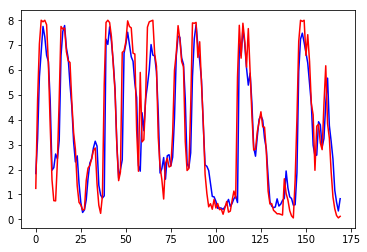

In [199]:
plt.plot(y_pred, 'b-', ytrain, 'r-')

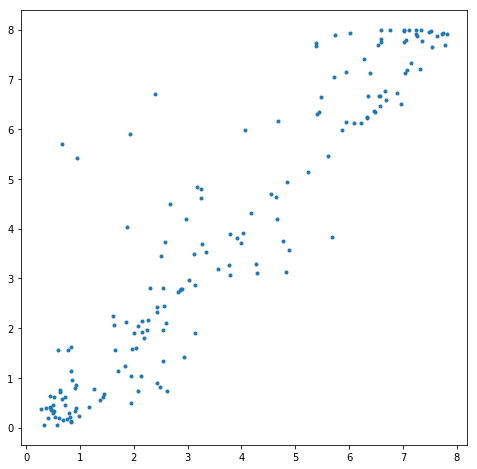

In [200]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, ytrain, '.')
plt.show()

In [201]:
y_pred = m_fit.predict(xtest)

In [202]:
mse = metrics.mean_squared_error(y_pred, ytest)
print(mse)

1.697369221932195


In [203]:
pd.Series(y_pred).shape

(70,)

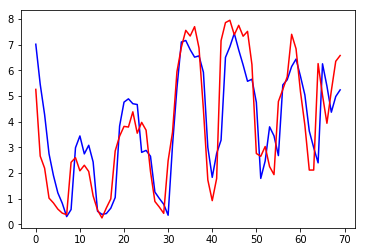

In [204]:
plt.plot(y_pred, 'b-', ytest, 'r-')

In [205]:
print(f'Accuracy: {m_fit.score(xtest,ytest)}')
print(f'R2: {metrics.r2_score(ytest,y_pred)}')

Accuracy: 0.7099011452883053
R2: 0.7099011452883052


In [186]:
bp.output_notebook()
fig = bp.figure(width=800, height=400)
fig.line(range(1, 71), y_pred, color='blue')
fig.line(range(1, 71), ytest, color='red')
bp.show(fig)

Loading BokehJS ...

In [123]:
date_and_preds = pd.DataFrame([df_agg.index[182:], ytest, y_pred]).T
date_and_preds.columns = ['date', 'ytest', 'ypred']
date_and_preds.head()

,date,ytest,ypred
0,2012-05-31 00:00:00,5.254,7.01448
1,2012-06-30 00:00:00,2.655,5.45481
2,2012-07-31 00:00:00,2.1825,4.27074
3,2012-08-31 00:00:00,1.016,2.74196
4,2012-09-30 00:00:00,0.8275,1.89883


In [124]:
date_and_preds.tail()

,date,ytest,ypred
65,2017-10-31 00:00:00,5.0275,6.25221
66,2017-11-30 00:00:00,3.934,5.38293
67,2017-12-31 00:00:00,5.2,4.36572
68,2018-01-31 00:00:00,6.35,4.97694
69,2018-02-28 00:00:00,6.575,5.23586


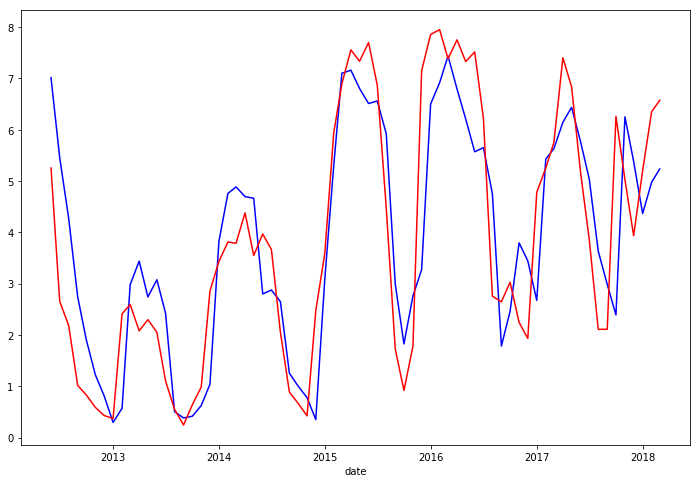

In [127]:
plt.figure(figsize=(12, 8))
sns.lineplot(date_and_preds.date, y_pred, color='blue')
sns.lineplot(date_and_preds.date, ytest, color='red')
plt.show()

# Looping through different values for window size and steps

Window size: 3     Step size: 2


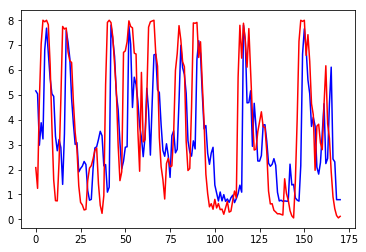

Window size: 3     Step size: 6


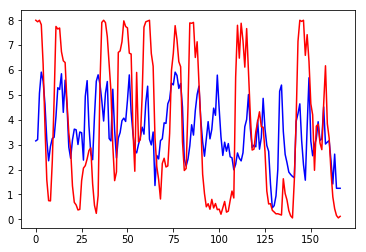

Window size: 3     Step size: 9


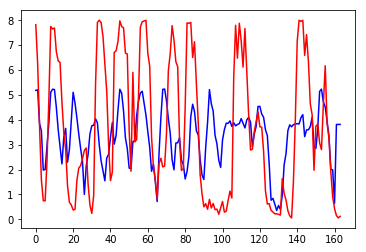

Window size: 3     Step size: 12


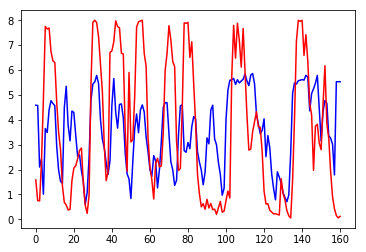

Window size: 6     Step size: 2


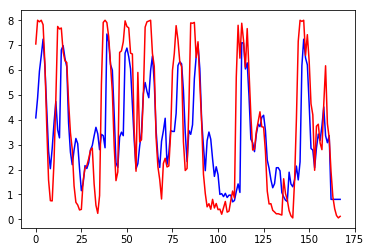

Window size: 6     Step size: 6


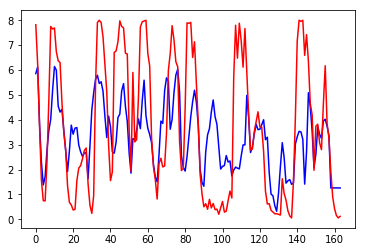

Window size: 6     Step size: 9


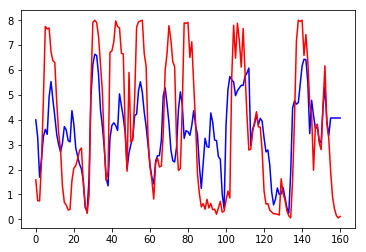

Window size: 6     Step size: 12


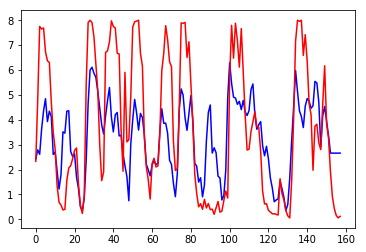

Window size: 9     Step size: 2


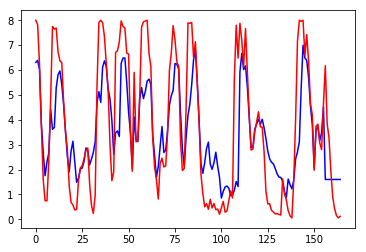

Window size: 9     Step size: 6


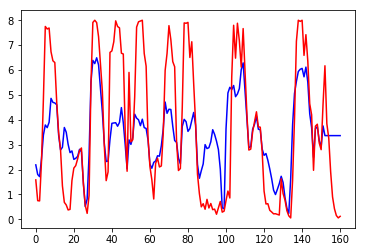

Window size: 9     Step size: 9


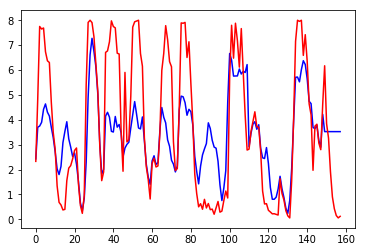

Window size: 9     Step size: 12


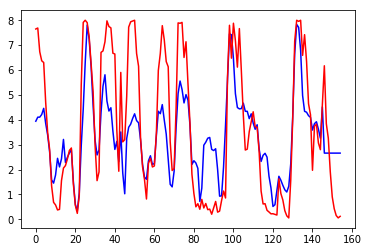

Window size: 12     Step size: 2


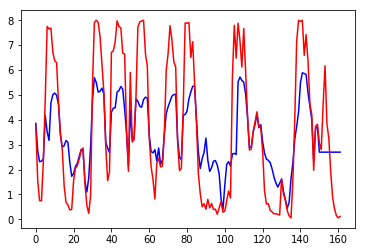

Window size: 12     Step size: 6


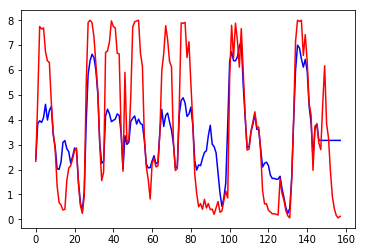

Window size: 12     Step size: 9


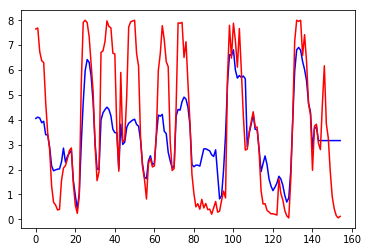

Window size: 12     Step size: 12


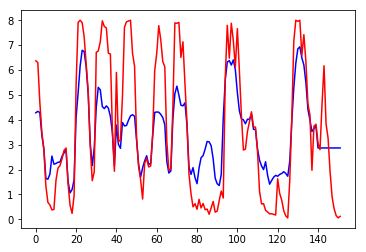

Window size: 18     Step size: 2


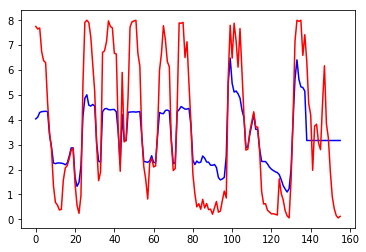

Window size: 18     Step size: 6


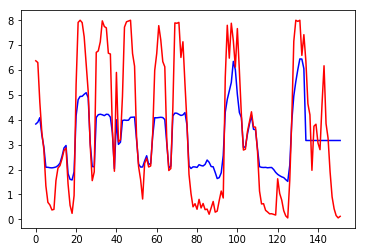

Window size: 18     Step size: 9


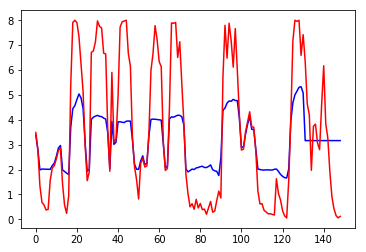

Window size: 18     Step size: 12


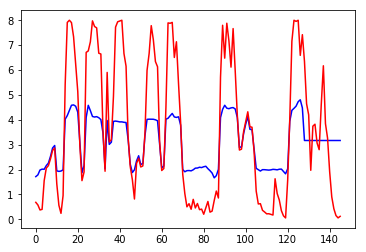

Window size: 24     Step size: 2


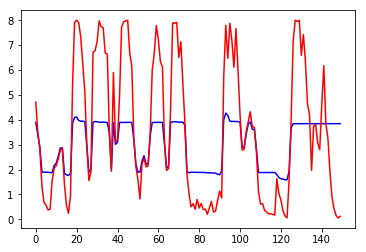

Window size: 24     Step size: 6


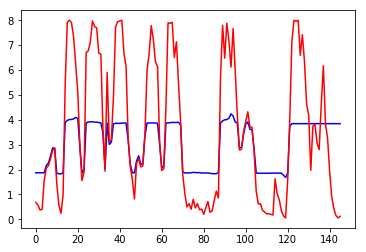

Window size: 24     Step size: 9


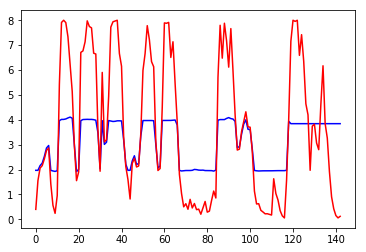

Window size: 24     Step size: 12


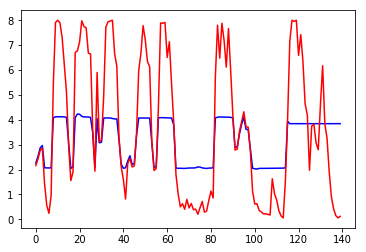

<function dict.items>

In [217]:
windows_to_try = [3, 6, 9, 12, 18, 24]
steps_to_try = [2, 6, 9, 12]

mse_dict = {}
for combo in list(itertools.product(windows_to_try, steps_to_try)):
    print(f'Window size: {combo[0]}     Step size: {combo[1]}')
    xtrain, ytrain = embed_data(train, combo[0], combo[1])
    xtest, ytest = embed_data(test, combo[0], combo[1])
    m = svm.SVR(kernel='rbf', C=1, gamma=0.1)
    # C is our regularization constant
    m_fit = m.fit(xtrain, ytrain)
    y_pred = m_fit.predict(xtrain)
    # mean squared error
    mse = metrics.mean_squared_error(y_pred, ytrain)
    mse_dict[f'window: {combo[0]}  step: {combo[1]}'] = mse
    plt.plot(y_pred, 'b-', ytrain, 'r-')
    plt.show()
    

In [221]:
mse_dict

{'window: 3  step: 2': 4.96725243822289,
 'window: 3  step: 6': 6.429438449114288,
 'window: 3  step: 9': 6.8620886436360236,
 'window: 3  step: 12': 5.954770885949325,
 'window: 6  step: 2': 3.5678360144723276,
 'window: 6  step: 6': 5.281715440560573,
 'window: 6  step: 9': 4.681330809850665,
 'window: 6  step: 12': 4.4112794434153475,
 'window: 9  step: 2': 3.079326928886625,
 'window: 9  step: 6': 3.9240783190185673,
 'window: 9  step: 9': 3.77726896014086,
 'window: 9  step: 12': 3.2228702617982936,
 'window: 12  step: 2': 3.1103343625783744,
 'window: 12  step: 6': 3.1416179398837425,
 'window: 12  step: 9': 3.2207206147034664,
 'window: 12  step: 12': 2.7473226636806665,
 'window: 18  step: 2': 3.3325786363154792,
 'window: 18  step: 6': 3.320669496586758,
 'window: 18  step: 9': 3.6490626956725745,
 'window: 18  step: 12': 3.913409408284696,
 'window: 24  step: 2': 4.407702570548337,
 'window: 24  step: 6': 4.548447813825713,
 'window: 24  step: 9': 4.56348892331667,
 'window: 